#Poiseuille flow

$$
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondy}{\partial_y}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\drondyy}{\partial_{yy}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this tutorial, we consider the classical $\DdQq{2}{9}$ to simulate a Poiseuille flow modeling by the Navier-Stokes equations.

##The $\DdQq{2}{9}$ for Navier-Stokes

The $\DdQq{2}{9}$ is defined by:

* a space step $\dx$ and a time step $\dt$ related to the scheme velocity $\lambda$ by the relation $\lambda=\dx/\dt$,

* nine velocities $\{(0,0), (\pm1,0), (0,\pm1), (\pm1, \pm1)\}$, identified in pyLBM by the 
numbers $0$ to $8$,

* nine polynomials used to build the moments

$$ \{1, \lambda X, \lambda Y, 3E-4, (9E^2-21E+8)/2, 3XE-5X, 3YE-5Y,X^2-Y^2, XY\},$$

where $E = X^2+Y^2$.

* three conserved moments $\rho$, $q_x$, and $q_y$,

* nine relaxation parameters (three are $0$ corresponding to conserved moments): $\{0,0,0,s_\mu,s_\mu,s_\eta,s_\eta,s_\eta,s_\eta\}$, where $s_\mu$ and $s_\eta$ are in $(0,2)$,

* equilibrium value of the non conserved moments
$$
\begin{aligned}\mke{3} &= -2\rho + 3(q_x^2+q_y^2)/(\rho_0\lambda^2), \\ \mke{4} &= \rho+3(q_x^2+q_y^2)/(2\rho_0\lambda^2), \\ \mke{5} &= -q_x/\lambda, \\ \mke{6} &= -q_y/\lambda, \\ \mke{7} &= (q_x^2-q_y^2)/(\rho_0\lambda^2), \\ \mke{8} &= q_xq_y/(\rho_0\lambda^2),\end{aligned}
$$

where $\rho_0$ is a given scalar.

This scheme is consistant at second order with the following equations (taken $\rho_0=1$)
\begin{gather*} \drondt\rho + \drondx q_x + \drondy q_y = 0,\\ \drondt q_x + \drondx (q_x^2+p) + \drondy (q_xq_y) = \mu \drondx (\drondx q_x + \drondy q_y ) + \eta (\drondxx+\drondyy)q_x, \\ \drondt q_y + \drondx (q_xq_y) + \drondy (q_y^2+p) = \mu \drondy (\drondx q_x + \drondy q_y ) + \eta (\drondxx+\drondyy)q_y,\end{gather*}
with $p=\rho\lambda^2/3$.

##Build the simulation with pyLBM

In the following, we build the dictionary of the simulation step by step.

###The geometry

The simulation is done on a rectangle of length $L$ and width $W$. We can use $L=W=1$.

We propose a dictionary that build the geometry of the domain. The labels of the bounds can be specified to different values for the moment.

In [10]:
%matplotlib inline

Geometry informations
	 spatial dimension: 2
	 bounds of the box: 
[[ 0.   1. ]
 [-0.5  0.5]]



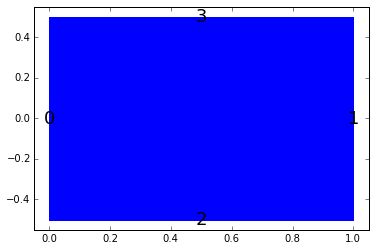

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import pyLBM

L, W = 1., 1.
dico_geom = {'box':{'x':[0,L], 'y':[-.5*W,.5*W], 'label':range(4)}}
geom = pyLBM.Geometry(dico_geom)
print geom
geom.visualize(viewlabel=True)

###The stencil

The stencil of the $\DdQq{2}{9}$ is composed by the nine following velocities in 2D:
$$
\begin{gather*}v_0=(0,0),\\ v_1=(1,0), \quad v_2=(0,1), \quad v_3=(-1,0), \quad v_4=(0,-1), \\ v_5=(1,1), \quad v_6=(-1,1), \quad v_7=(-1,-1), \quad v_8=(1,-1).\end{gather*}
$$

Stencil informations
	 * spatial dimension: 2
	 * maximal velocity in each direction: [1 1 None]
	 * minimal velocity in each direction: [-1 -1 None]
	 * Informations for each elementary stencil:
		stencil 0
		 - number of velocities:  9
		 - velocities: (0: 0, 0), (1: 1, 0), (2: 0, 1), (3: -1, 0), (4: 0, -1), (5: 1, 1), (6: -1, 1), (7: -1, -1), (8: 1, -1), 



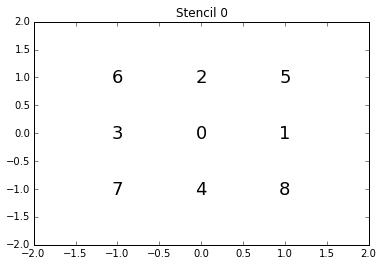

In [12]:
dico_sten = {
    'dim':2,
    'schemes':[{'velocities':range(9)}],
}
sten = pyLBM.Stencil(dico_sten)
print sten
sten.visualize()

###The domain

In order to build the domain of the simulation, the dictionary should contain the space step $\dx$ and the stencils of the velocities (one for each scheme). 

Domain informations
	 spatial dimension: 2
	 bounds of the box: bounds = [[ 0.   1. ]
 [-0.5  0.5]]
	 space step: dx= 1.000e-01



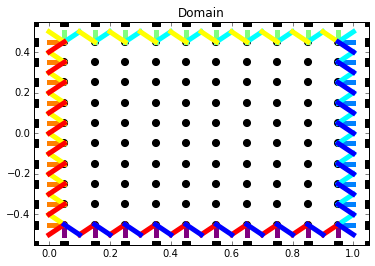

In [13]:
dico_dom = {
    'space_step':.1,
    'box':{'x':[0,L], 'y':[-.5*W,.5*W], 'label':range(4)},
    'schemes':[{'velocities':range(9)}],
}
dom = pyLBM.Domain(dico_dom)
print dom
dom.visualize(view_distance=True)

###The scheme

In pyLBM, a simulation can be performed by using several coupled schemes. In this example, a single scheme is used and defined through a list of one single dictionary. This dictionary should contain:

* 'velocities': a list of the velocities
* 'conserved_moments': a list of the conserved moments as sympy variables
* 'polynomials': a list of the polynomials that define the moments
* 'equilibrium': a list of the equilibrium value of all the moments
* 'relaxation_parameters': a list of the relaxation parameters ($0$ for the conserved moments)
* 'init': a dictionary to initialize the conserved moments

(see the documentation for more details)

In order to fix the bulk ($\mu$) and the shear ($\eta$) viscosities, we impose
$$ s_\eta = \frac{2}{1+\eta d}, \qquad s_\mu = \frac{2}{1+\mu d}, \qquad d = \frac{6}{\lambda\rho_0\dx}.$$

The scheme velocity could be taken to $1$ and the inital value of $\rho$ to $\rho_0=1$, $q_x$ and $q_y$ to $0$.

In order to accelerate the simulation, we can use another generator. The default generator is Numpy (pure python). We can use for instance Cython that generates a more efficient code. This generator can be activated by using  'generator': pyLBM.generator.CythonGenerator in the dictionary.

In [14]:
import sympy as sp
X, Y, rho, qx, qy, LA = sp.symbols('X, Y, rho, qx, qy, LA')

# parameters
dx = 1./128  # spatial step
la = 1.      # velocity of the scheme
L = 1        # length of the domain
W = 1        # width of the domain
rhoo = 1.    # mean value of the density
mu   = 1.e-3 # shear viscosity
eta = 1.e-1 # bulk viscosity
# initialization
xmin, xmax, ymin, ymax = 0.0, L, -0.5*W, 0.5*W
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0/(0.5+eta*dummy)
s_q = s_eta
s_es = s_mu
s  = [0.,0.,0.,s_mu,s_es,s_q,s_q,s_eta,s_eta]
dummy = 1./(LA**2*rhoo)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

dico_sch = {
    'box':{'x':[xmin, xmax], 'y':[ymin, ymax], 'label':0},
    'space_step':dx,
    'scheme_velocity':la,
    'parameters':{LA:la},
    'schemes':[
        {
            'velocities':range(9),
            'conserved_moments':[rho, qx, qy],
            'polynomials':[
                1, LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                (9*(X**2+Y**2)**2-21*(X**2+Y**2)+8)/2,
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters':s,
            'equilibrium':[
                rho, qx, qy,
                -2*rho + 3*q2,
                rho+1.5*q2,
                -qx/LA, -qy/LA,
                qx2-qy2, qxy
            ],
            'init':{rho:rhoo, qx:0., qy:0.},
        },
    ],
    'generator': pyLBM.generator.CythonGenerator,
}
sch = pyLBM.Scheme(dico_sch)
print sch

Scheme informations
	 spatial dimension: dim=2
	 number of schemes: nscheme=1
	 number of velocities:
    Stencil.nv[0]=9
	 velocities value:
    v[0]=(0: 0, 0), (1: 1, 0), (2: 0, 1), (3: -1, 0), (4: 0, -1), (5: 1, 1), (6: -1, 1), (7: -1, -1), (8: 1, -1), 
	 polynomials:
    P[0]=Matrix([[1], [LA*X], [LA*Y], [3*X**2 + 3*Y**2 - 4], [-21*X**2/2 - 21*Y**2/2 + 9*(X**2 + Y**2)**2/2 + 4], [3*X*(X**2 + Y**2) - 5*X], [3*Y*(X**2 + Y**2) - 5*Y], [X**2 - Y**2], [X*Y]])
	 equilibria:
    EQ[0]=Matrix([[rho], [qx], [qy], [-2*rho + 3.0*qx**2/LA**2 + 3.0*qy**2/LA**2], [rho + 1.5*qx**2/LA**2 + 1.5*qy**2/LA**2], [-qx/LA], [-qy/LA], [1.0*qx**2/LA**2 - 1.0*qy**2/LA**2], [1.0*qx*qy/LA**2]])
	 relaxation parameters:
    s[0]=[0.0, 0.0, 0.0, 1.1312217194570136, 1.1312217194570136, 0.025706940874035987, 0.025706940874035987, 0.025706940874035987, 0.025706940874035987]
	 moments matrices
M = [Matrix([
[ 1,  1,  1,   1,   1,  1,   1,   1,   1],
[ 0, LA,  0, -LA,   0, LA, -LA, -LA,  LA],
[ 0,  0, LA,   0, -LA, 

##Run the simulation

For the simulation, we take

* The domain $x\in(0, L)$ and $y\in(-W/2,W/2)$, $L=2$, $W=1$,
* the viscosities $\mu=10^{-2}=\eta=10^{-2}$, 
* the space step $\dx=1/128$, the scheme velocity $\lambda=1$, 
* the mean density $\rho_0=1$.

Concerning the boundary conditions, we impose the velocity on all the edges by a bounce-back condition with a source term that reads
$$q_x(x, y) = \rho_0 v_{\text{max}} \Bigl( 1 - \frac{4y^2}{W^2} \Bigr), \qquad q_y(x, y) = 0,$$
with $v_{\text{max}}=0.1$.

We compute the solution for $t\in(0,50)$ and we plot several slices of the solution during the simulation. 

This problem has an exact solution given by
$$ q_x = \rho_0 v_{\text{max}} \Bigl( 1 - \frac{4y^2}{W^2} \Bigr), \qquad q_y = 0, \qquad p = p_0 + K x, $$
where the pressure gradient $K$ reads
$$K = -\frac{8 v_{\text{max}} \eta}{W^2}.$$

We compute the exact and the numerical gradients of the pressure.

Exact pressure gradient    : -8.000e-03
Numerical pressure gradient: -7.854e-03


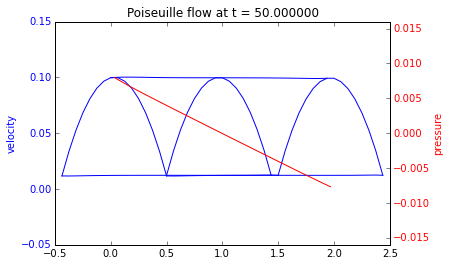

In [15]:
X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc(f, m, x, y, scheme):
    # condition for Cython generator
    m[:, 1] = rhoo * vmax * (1.-4.*y**2/W**2)
    m[:, 2] = 0.
    # condition for Numpy generator
    # m[1] = rhoo * vmax * (1.-4.*y**2/W**2)
    # m[2] = 0.
    scheme.equilibrium(m)
    scheme.m2f(m, f)

def plot_coupe(sol):
    fig, ax1 = plt.subplots()
    plt.hold(True)
    ax2 = ax1.twinx()
    ax1.cla()
    ax2.cla()
    mx = int(sol.domain.N[0]/2-1)
    my = int(sol.domain.N[1]/2-1)
    x = sol.domain.x[0][1:-1]
    y = sol.domain.x[1][1:-1]
    u = sol.m[0][1][1:-1,1:-1] / rhoo
    for i in [0,mx,-1]:
        ax1.plot(y+x[i], u[i, :], 'b')
    for j in [0,my,-1]:
        ax1.plot(x+y[j], u[:,j], 'b')
    ax1.set_ylabel('velocity', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    ax1.set_ylim(-.5*rhoo*vmax, 1.5*rhoo*vmax)
    p = sol.m[0][0][1:-1,my] * la**2 / 3.0
    p -= np.average(p)
    ax2.plot(x, p, 'r')
    ax2.set_ylabel('pressure', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    ax2.set_ylim(pressure_gradient*L, -pressure_gradient*L)
    plt.title('Poiseuille flow at t = {0:f}'.format(sol.t))
    plt.draw()
    plt.pause(1.e-3)

# parameters
dx = 1./16  # spatial step
la = 1.      # velocity of the scheme
Tf = 50      # final time of the simulation
L = 2        # length of the domain
W = 1        # width of the domain
vmax = 0.1   # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
mu = 1.e-2   # bulk viscosity
eta = 1.e-2  # shear viscosity
pressure_gradient = - vmax * 8.0 / W**2 * eta
# initialization
xmin, xmax, ymin, ymax = 0.0, L, -0.5*W, 0.5*W
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0/(0.5+eta*dummy)
s_q = s_eta
s_es = s_mu
s  = [0.,0.,0.,s_mu,s_es,s_q,s_q,s_eta,s_eta]
dummy = 1./(LA**2*rho)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

dico = {
    'box':{'x':[xmin, xmax], 'y':[ymin, ymax], 'label':0},
    'space_step':dx,
    'scheme_velocity':la,
    'parameters':{LA:la},
    'schemes':[
        {
            'velocities':range(9),
            'conserved_moments':[rho, qx, qy],
            'polynomials':[
                1, LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                (9*(X**2+Y**2)**2-21*(X**2+Y**2)+8)/2,
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters':s,
            'equilibrium':[
                rho, qx, qy,
                -2*rho + 3*q2,
                rho+3/2*q2,
                -qx/LA, -qy/LA,
                qx2-qy2, qxy
            ],
            'init':{rho:rhoo, qx:0., qy:0.},
        },
    ],
    'boundary_conditions':{
        0:{'method':{0: pyLBM.bc.bouzidi_bounce_back}, 'value':bc}
    },
    'generator': pyLBM.generator.CythonGenerator,
}

sol = pyLBM.Simulation(dico)
while (sol.t<Tf):
    sol.one_time_step()
sol.f2m()
plot_coupe(sol)
ny = int(sol.domain.N[1]/2)
num_pressure_gradient = (sol.m[0][0][-2,ny] - sol.m[0][0][1,ny]) / (xmax-xmin) * la**2/ 3.0
print "Exact pressure gradient    : {0:10.3e}".format(pressure_gradient)
print "Numerical pressure gradient: {0:10.3e}".format(num_pressure_gradient)